# How to solve optimization problem in Pyleecan

This tutorial explains how to use Pyleecan to solve **constrained global optimization** problem.

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Optimization.ipynb).  

The tutorial introduces the different objects to define that enable to parametrize each aspect of the optimization. To do so, we will present an example to maximize the average torque and minimize the first torque harmonic by varying the stator slot opening and the rotor external radius and by adding a constraint on torque ripple.

## Problem definition

The object [**OptiProblem**](https://www.pyleecan.org/pyleecan.Classes.OptiObjFunc.html) contains all the optimization problem characteristics:  

- the output that contains the simulation default parameters  
- the design variable to vary some parameters of the simulation (e.g. input current, topology of the machine)  
- the objective functions to minimize for the simulation  
- some constraints (optional)  

### Default Output definition

To define the problem, we first define an output which contains the default simulation and its results. The optimization process will be based on this output, each evaluation will copy the simulation, set the value of the design variables and run the new simulation.

For this example, we use the simulation defined in the tutorial [How to define a simulation to call FEMM](https://www.pyleecan.org/tuto_Simulation_FEMM.html), but we decrease the precision of the FEMM mesh to speed up the calculations.

In [1]:
# Change of directory to have pyleecan in the path
from os import chdir
chdir('..')

In [2]:
from numpy import ones, pi, array, linspace
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.Output import Output
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Functions.load import load

# Import the machine from a script
IPMSM_A = load('pyleecan/Data/Machine/IPMSM_A.json')
rotor_speed = 2000 # [rpm] 

# Create the Simulation
mySimu = Simu1(name="EM_SIPMSM_AL_001", machine=IPMSM_A)   

# Defining Simulation Input
mySimu.input = InputCurrent()

# time discretization [s]
mySimu.input.Nt_tot = 16 

# Angular discretization along the airgap circonference for flux density calculation
mySimu.input.Na_tot = 1024 

# Rotor speed as a function of time [rpm]
mySimu.input.N0 = rotor_speed

# Stator currents as a function of time, each column correspond to one phase [A]
mySimu.input.Id_ref = -100 # [A]
mySimu.input.Iq_ref = 200 # [A]

# Definition of the magnetic simulation (is_mmfr=False => no flux from the magnets)
mySimu.mag = MagFEMM(
    type_BH_stator=0, # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    type_BH_rotor=0,  # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    angle_stator=0,  # Angular position shift of the stator
    file_name = "", # Name of the file to save the FEMM model
    is_symmetry_a=True,   # 0 Compute on the complete machine, 1 compute according to sym_a and is_antiper_a
    sym_a = 4, # Number of symmetry for the angle vector
    is_antiper_a=True, # To add an antiperiodicity to the angle vector
    Kmesh_fineness = 0.2, # Decrease mesh precision
    Kgeo_fineness = 0.2, # Decrease mesh precision
)

# We only use the magnetic part 
mySimu.force = None
mySimu.struct = None 

# Set the default output for the optimization
defaultOutput = Output(simu=mySimu)

### Minimization problem definition

To setup the optimization problem, we define some objective functions using the [**DataKeeper**](https://www.pyleecan.org/pyleecan.Classes.DataKeeper.html) object. 

Each objective function is stored in the *keeper* attribute of a **DataKeeper**. This type of function takes an output object in argument and returns a float to **minimize**. 
We gather the objective functions into a dictionnary.

In [3]:
from pyleecan.Classes.DataKeeper import DataKeeper
import numpy as np

# Objective functions
def tem_av(output):
    """Return the average torque opposite (opposite to be maximized)"""
    return -abs(output.mag.Tem_av)

def harm1(output):
    """Return the first torque harmonic """
    N = output.mag.time.size
    
    # Compute the real fft of the torque
    sp = 2 / N * np.abs(np.fft.rfft(output.mag.Tem.values))
    
    # Return the first torque harmonic
    return sp[1] 

my_obj = [
    DataKeeper(
        name="Maximization of the average torque",
        symbol="Tem_av",
        unit="N.m",
        keeper=tem_av,
    ),
    DataKeeper(
        name="Minimization of the first torque harmonic",
        symbol="Tem_h1",
        unit="N.m",
        keeper=harm1,
    ),
]

### Design variables
We use the object [**OptiDesignVar**](https://www.pyleecan.org/pyleecan.Classes.OptiDesignVar.html) to define the design variables. 


To define a design variable, we have to specify different attributes:  

- *name* to define the design variable name
- *symbol* to access to the variable
- *unit* to define the variable unit
- *type_var* to specify the variable "type":  
    - *interval* for continuous variables  
    - *set* for discrete variables  
- *space* to set the variable bound
- *setter* to access to the variable in the output's simu object. This attribute **must begin by "simu"**.  
- *get_value* to define the variable for the first generation, the function takes the space in argument and returns the variable value  

We store the design variables in a dictionnary that will be in argument of the problem. For this example, we define two design variables: 

1. Stator slot opening: can be any value between 0 and the slot width.   
2. Rotor external radius: can be one of the four value specified \[99.8%, 99.9%, 100%, 100.1%\] of the default rotor external radius     

In [4]:
from pyleecan.Classes.OptiDesignVar import OptiDesignVar
import random

# Design variables
my_design_var = [
    OptiDesignVar(
        name="Stator slot opening",
        symbol = "SW0",
        unit = "m",
        type_var="interval",
        space=[
            0 * defaultOutput.simu.machine.stator.slot.W2,
            defaultOutput.simu.machine.stator.slot.W2,
        ],
        get_value=lambda space: random.uniform(*space), # To initiate randomly the first generation
        setter="simu.machine.stator.slot.W0", # Variable to edit
        
    ),
    OptiDesignVar(
        name= "Rotor ext radius",
        symbol = "Rext",
        unit = "m",
        type_var="set",
        space=[
            0.998 * defaultOutput.simu.machine.rotor.Rext,
            0.999 * defaultOutput.simu.machine.rotor.Rext,
            defaultOutput.simu.machine.rotor.Rext,
            1.001 * defaultOutput.simu.machine.rotor.Rext,
        ],
        get_value=lambda space: random.choice(space),
        setter = "simu.machine.rotor.Rext"
    ),
]

### Constraints

The class [**OptiConstraint**](https://www.pyleecan.org/pyleecan.Classes.OptiConstraint.html) enables to define some constraint. For each constraint, we have to define the following attributes:  

- name  
- type_const: type of constraint  
    - "=="  
    - "<="  
    - "<"  
    - ">="  
    - ">"  
- value: value to compare  
- get_variable: function which takes output in argument and returns the constraint value  

We also store the constraints into a dict.

In [5]:
from pyleecan.Classes.OptiConstraint import OptiConstraint
my_constraint = [
    OptiConstraint(
        name = "const1",
        type_const = "<=",
        value = 700,
        get_variable = lambda output: abs(output.mag.Tem_rip_pp),
    )
]

### Evaluation function


We can create our own evaluation function if needed by defining a function which only take an output in argument. 

For this example we keep the default one which calls the `Output.simu.run` method. 

In [6]:
from pyleecan.Classes.OptiProblem import OptiProblem


# Problem creation
my_prob = OptiProblem(
    output=defaultOutput, 
    design_var=my_design_var, 
    obj_func=my_obj,
    constraint = my_constraint,
    eval_func = None # To keep the default evaluation function
)

## Solver

The class [**OptiGenAlgNsga2**](https://www.pyleecan.org/pyleecan.Classes.OptiGenAlgNsga2Deap.html) enables to solve our problem using [NSGA-II](https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf) genetical algorithm. The algorithm takes several parameters:  

|Parameter|Description|Type|Default Value|  
| :-: | :- | :-: | :-: |  
|*problem*|Problem to solve|**OptiProblem**|mandatory|
|*size\_pop*| Population size per generation|**int**|40|  
|*nb\_gen*|Generation number|**int**|100|  
|*p\_cross*|Crossover probability|**float**|0.9|  
|*p\_mutate*|Mutation probability|**float**|0.1|  

  
The `solve` method performs the optimization and returns an [**OutputMultiOpti**](https://www.pyleecan.org/pyleecan.Classes.OutputMultiOpti.html) object which contains the results.

In [7]:
from pyleecan.Classes.OptiGenAlgNsga2Deap import OptiGenAlgNsga2Deap

# Solve problem with NSGA-II
solver = OptiGenAlgNsga2Deap(problem=my_prob, size_pop=16, nb_gen=8, p_mutate=0.5)
res = solver.solve()

16:24:12 Starting optimization... 
	Log file: C:\Users\eomys\AppData\Roaming\pyleecan\Pyleecan_optimization.log
	Number of generations: 8
	Population size: 16

16:24:12  gen     0: 100%,    0 errors,   0 infeasible.
16:31:46  gen     1: 100%,    0 errors,   0 infeasible.
16:40:23  gen     2: 100%,    0 errors,   0 infeasible.
16:48:47  gen     3: 100%,    0 errors,   0 infeasible.
16:57:52  gen     4: 100%,    0 errors,   0 infeasible.
17:07:01  gen     5: 100%,    0 errors,   0 infeasible.
17:15:13  gen     6: 100%,    0 errors,   0 infeasible.
17:23:42  gen     7: 100%,    0 errors,   0 infeasible.


During the algorithm the object displays some data containing:

- number of errors: failure during the objective function execution
- number of infeasible: number of individual with constraints violations

## Plot results

**OutputMultiOpti** has several methods to display some results:  

- `plot_generation`: to plot individuals for in 2D  
- `plot_pareto`: to plot the pareto front in 2D    

<IPython.core.display.Javascript object>


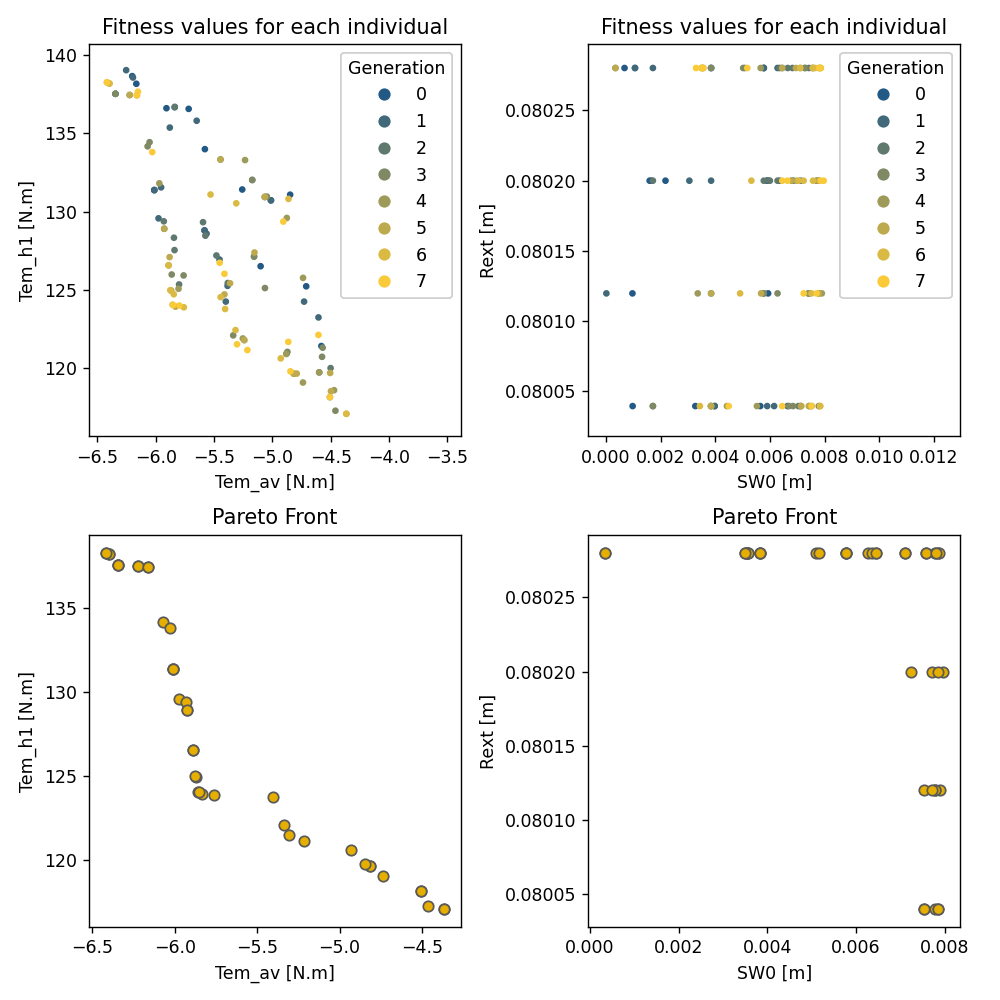

In [8]:
%matplotlib notebook 
import matplotlib.pyplot as plt 

# Create a figure containing 4 subfigures (axes) 
fig, axs = plt.subplots(2,2, figsize=(8,8))

# Plot every individual in the fitness space 
res.plot_generation(
    x_symbol = "Tem_av", # symbol of the first objective function or design variable
    y_symbol = "Tem_h1", # symbol of the second objective function or design variable
    ax = axs[0,0] # ax to plot
)

# Plot every individual in the design space 
res.plot_generation(
    x_symbol = "SW0", 
    y_symbol = "Rext", 
    ax = axs[0,1]
)

# Plot pareto front in fitness space 
res.plot_pareto(
    x_symbol = "Tem_av", 
    y_symbol = "Tem_h1", 
    ax = axs[1,0]
)

# Plot pareto front in design space 
res.plot_pareto(
    x_symbol = "SW0", 
    y_symbol = "Rext", 
    ax = axs[1,1]
)

fig.tight_layout()
